In [2]:
import pystac_client
import planetary_computer
import geopandas as gpd
import dask
import leafmap
import stackstac
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pystac_client import Client
import rioxarray as rx
import xarray
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
from xrspatial.zonal import stats
from pystac.extensions.eo import EOExtension as eo
from dask.diagnostics import ProgressBar
from rasterio.enums import Resampling

In [4]:
pip install stackstac==0.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: stackstac
    Found existing installation: stackstac 0.4.3
    Uninstalling stackstac-0.4.3:
      Successfully uninstalled stackstac-0.4.3
Note: you may need to restart the kernel to use updated packages.


In [3]:
print("stackstac version" , stackstac.__version__)

stackstac version 0.5.0


In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/smuda@clarku.edu/proxy/34455/status,
Dashboard: /user/smuda@clarku.edu/proxy/34455/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44895,Workers: 4
Dashboard: /user/smuda@clarku.edu/proxy/34455/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:42185,Total threads: 1
Dashboard: /user/smuda@clarku.edu/proxy/42663/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:37967,


<Axes: >

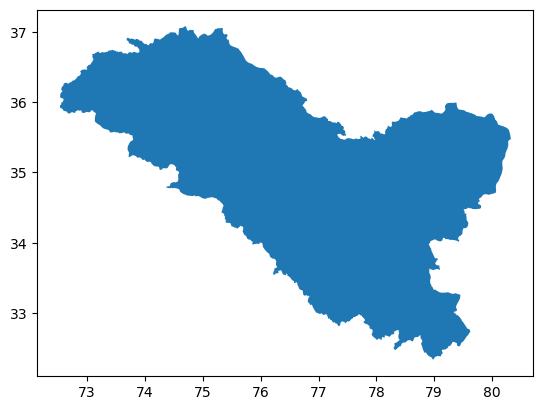

In [3]:
geojson_path = 'india_states.geojson'
boundary = gpd.read_file(geojson_path)
ladakh = boundary.loc[boundary['ST_NM'] == 'Ladakh']
ladakh.plot()

<Axes: >

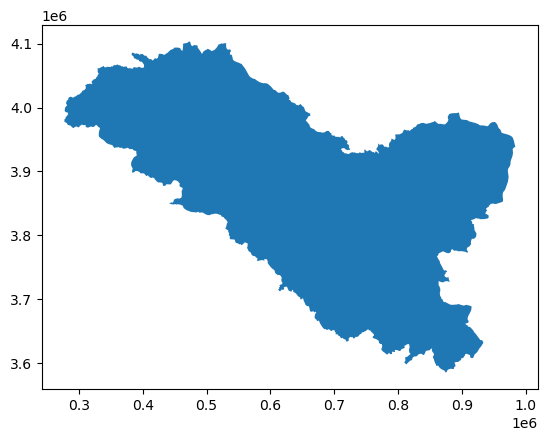

In [5]:
target_epsg_code = 32643  # UTM Zone
# Reproject the GeoDataFrame to the target PCS
ladakh_projected = ladakh.to_crs(epsg=target_epsg_code)
ladakh_geometry = ladakh_projected.geometry
ladakh_projected.plot()

In [6]:
srtm_90 = rx.open_rasterio('SRTMGL3.tif', masked=True, chunks=['auto'])

In [7]:
srtm_90_type = srtm_90.astype('float64')

In [8]:
# Caluculate new height and width using upscale_factor
upscale_factor = 3
new_width = srtm_90_type.rio.width * upscale_factor
new_height = srtm_90_type.rio.height * upscale_factor
 
#upsample raster
srtm_dem = srtm_90_type.rio.reproject(target_epsg_code, shape=(int(new_height), int(new_width)), resampling=Resampling.bilinear)
 

In [48]:
# target_epsg_code = "EPSG:32643"
# dem_projected = srtm_dem.rio.reproject(dst_crs=target_epsg_code)

In [9]:
clipped_raster = srtm_dem.rio.clip(ladakh_geometry)

In [11]:
clipped_raster_masked = clipped_raster.where(clipped_raster < 9000, 0.0)  

In [12]:
print("The minimum raster value is: ", np.nanmin(clipped_raster_masked.data))
print("The maximum raster value is: ", np.nanmax(clipped_raster_masked.data))

The minimum raster value is:  0.0
The maximum raster value is:  8545.599598167035


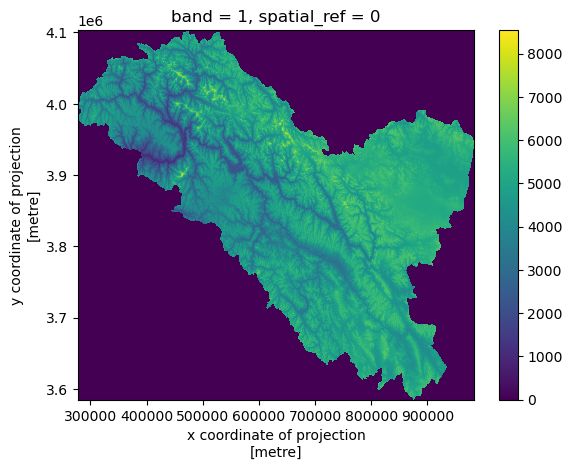

In [17]:
clipped_raster_masked[0].plot.imshow()

In [ ]:
clipped_raster.plot.hist(bins=[0,2000,3000,4000,5000,6000,9000])

In [14]:
# Defines the bins for pixel values
class_bins = (1, 3000, 4000, 5000, 6000, 9000)


dem_classified = xarray.apply_ufunc(
    np.digitize,
    clipped_raster_masked[0],
    class_bins,
    keep_attrs=True
)

In [15]:
mask = dem_classified.where(dem_classified != 6, 0, 1)

# Apply the mask to the original raster
dem_classified_new = dem_classified.where(mask)

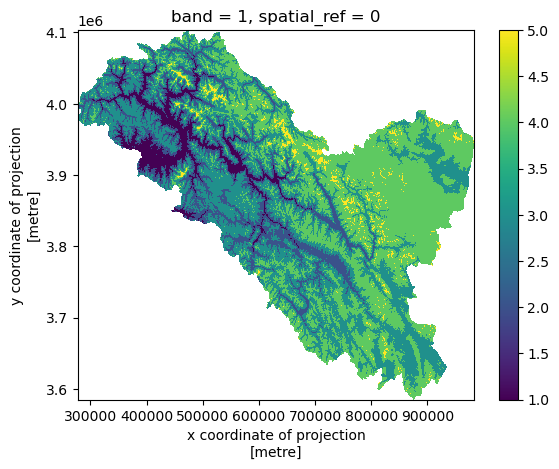

In [16]:
dem_classified_new.plot.imshow()

In [24]:
# dem_classified_new =  dem_classified_new.astype('int32')
# transform = dem_classified_new.rio.transform()

In [27]:
shapes_gen = shapes(dem_classified_new, transform=transform)
geoms=[]
values=[]
for geom, value in shapes_gen:
    geoms.append(shape(geom))
    values.append(value)


In [28]:
gdf_dem = gpd.GeoDataFrame({'elevation_class' : values, 'geometry': geoms}, crs = dem_classified_new.rio.crs)
union_dem = gdf_dem.dissolve(by='elevation_class')

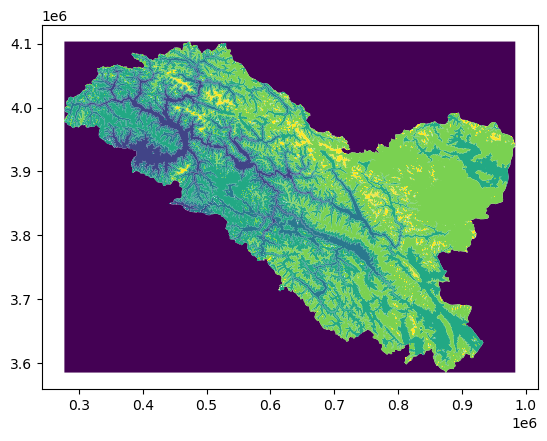

In [29]:
# fig, ax = plt.subplots(figsize=(8,8))
#ax.set_aspect('equal')
union_dem.plot(legend=True, cmap='viridis')
plt.show()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/smuda@clarku.edu/proxy/8787/status,
Dashboard: /user/smuda@clarku.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43967,Workers: 4
Dashboard: /user/smuda@clarku.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:33513,Total threads: 1
Dashboard: /user/smuda@clarku.edu/proxy/32799/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:46261,


In [12]:
bbox = [72, 32, 81, 38]
time_of_interest = "2022-05-30/2022-05-31"

In [13]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)

In [18]:
search = catalog.search(
     collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 10 Items


In [22]:
landsat_data = stackstac.stack(items, bounds_latlon=bbox, epsg=32643, resolution = 60)
landsat_data

<xarray.DataArray 'stackstac-ef509b6148b2fba0281a985e41727031' (time: 10,
                                                                band: 17,
                                                                y: 11309,
                                                                x: 14178)>
dask.array<fetch_raster_window, shape=(10, 17, 11309, 14178), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2022-05-30...
    id                                       (time) <U54 'S2A_MSIL2A_20220530...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 2.165e+05 ... 1.067e+06
  * y                                        (y) float64 4.223e+06 ... 3.544e+06
    platform                                 <U11 'Sentinel-2A'
    ...                                       ...
    proj:shape                               (band) object [10980, 10980] ......
    title                                    (band) <U37 'Aerosol optical thi...
    common_name                              (band) object None ... None
    center_wavelength                        (band) object None 0.443 ... None
    full_width_half_max                      (band) object None 0.027 ... None
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(216540, 3544320, 1067220, 422...
    crs:         epsg:32643
    transform:   | 60.00, 0.00, 216540.00|\n| 0.00,-60.00, 4222860.00|\n| 0.0...
    resolution:  60

In [16]:
lwir11 = landsat_data.sel(band="lwir11")


In [26]:
lwir11 = landsat_data.sel(band="B11")


In [22]:
st_clipped = lwir11.rio.clip(ladakh_geometry, drop=True)


In [23]:
monthly_mean_st = st_clipped.groupby('time.month').mean(dim='time')

In [27]:
print("The minimum raster value is: ", np.nanmin(lwir11.data).compute())
print("The maximum raster value is: ", np.nanmax(lwir11.data).compute())

The minimum raster value is:  1015.0
The maximum raster value is:  16286.0


In [ ]:
dem_proj_match = dem_classified_new.rio.reproject_match(st_clipped)

In [ ]:
monthly_mean_st[0].plot.imshow()

In [51]:
stats = stats(zones=dem_proj_match, values=monthly_mean_st[0],zone_ids=[2.0,3.0,4.0], stats_funcs=["mean"])
stats

ValueError: input arrays must have same type

In [ ]:
for time_idx in range(2):
    # Get the file path for the specific time step
    raster_file_path = monthly_mean_st.isel(time=time_idx).values

    # Open the raster data for the current time step
    # with rasterio.open(raster_file_path) as src:
    #     raster_data = src.read(1)
    #     transform = src.transform

    # Rasterize the vector data
    #rasterized_zones = zones.geometry.rasterize(fill=0, out_shape=raster_data.shape, transform=transform, dtype=np.uint8)

    # Calculate zonal statistics
    stats = zonal_stats(dem_classified_new, monthly_mean_st.isel(time=time_idx).values) #, affine=transform, stats="mean", all_touched=True)
    union_dem[f"mean_value_time_{time_idx}"] = [stat["mean"] for stat in stats]


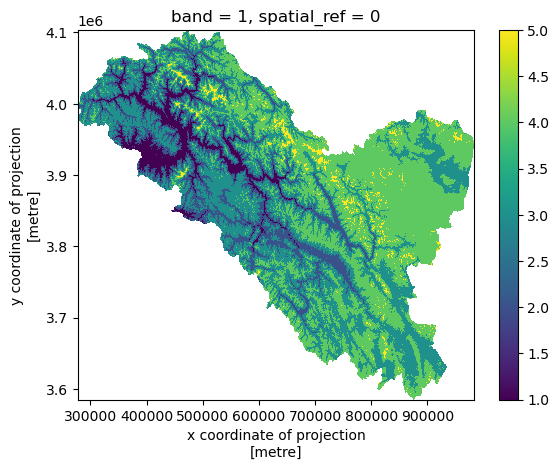

In [28]:
dem_proj_match.plot.imshow()

In [50]:
dem_proj_match.dtype

dtype('float64')

In [ ]:
ladakh_clipped.plot.imshow(cmap='viridis')
plt.show()

In [46]:
monthly_mean_st[0].dtype

dtype('float64')